<a href="https://colab.research.google.com/github/arianesannt/Tech_challenge_fase2/blob/main/Tech_challenge_Ibovespa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [1]:
# No colab não precisa instalar a Prophet, apenas a biblioteca yfinance

#!pip install yfinance --upgrade --no-cache-dir

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_datareader.data as web
yf.pdr_override()


# Adequação do dataset

In [3]:
# buscando dados da Ibovespa diretamente da web

dados = web.get_data_yahoo('^BVSP', period='15y')

[*********************100%%**********************]  1 of 1 completed


In [4]:
dados

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-23,37891.000000,38660.00000,36744.000000,38132.000000,38132.000000,1433000
2009-01-26,38130.000000,39065.00000,37831.000000,38509.000000,38509.000000,1493800
2009-01-27,38511.000000,39025.00000,38422.000000,38699.000000,38699.000000,1423800
2009-01-28,38704.000000,40438.00000,38704.000000,40227.000000,40227.000000,2132400
2009-01-29,40229.000000,40229.00000,39369.000000,39638.000000,39638.000000,1330400
...,...,...,...,...,...,...
2024-01-17,129293.000000,129296.00000,128312.000000,128524.000000,128524.000000,9952500
2024-01-18,128524.000000,129047.00000,127316.000000,127316.000000,127316.000000,12460800
2024-01-19,127319.000000,127820.00000,126533.000000,127636.000000,127636.000000,11956900


In [5]:
# para usar o prophet, vou precisar somente da data e da coluna "adj close", que são os preços ajustados

dados = dados['Adj Close']
dados

Date
2009-01-23     38132.000000
2009-01-26     38509.000000
2009-01-27     38699.000000
2009-01-28     40227.000000
2009-01-29     39638.000000
                  ...      
2024-01-17    128524.000000
2024-01-18    127316.000000
2024-01-19    127636.000000
2024-01-22    126602.000000
2024-01-23    127651.859375
Name: Adj Close, Length: 3711, dtype: float64

In [6]:
# para uso do modelo3, to criando já um dataset sem o período do covid

data_inicio = pd.to_datetime('2020-01-01')
data_fim = pd.to_datetime('2020-12-31')
dados3 = dados.loc[(dados.index < data_inicio) | (dados.index > data_fim)]
dados3 = pd.DataFrame(dados3)
dados3.reset_index('Date', inplace=True)
dados3.columns = ['ds', 'y']
dados3

,ds,y
0,2009-01-23,38132.000000
1,2009-01-26,38509.000000
2,2009-01-27,38699.000000
3,2009-01-28,40227.000000
4,2009-01-29,39638.000000
...,...,...
3458,2024-01-17,128524.000000
3459,2024-01-18,127316.000000
3460,2024-01-19,127636.000000
3461,2024-01-22,126602.000000


In [7]:
# o prophet só trabalha com Dataframe, então precisa transformar
type(dados)

pandas.core.series.Series

In [8]:
dados = pd.DataFrame(dados)
dados

,Adj Close
Date,
2009-01-23,38132.000000
2009-01-26,38509.000000
2009-01-27,38699.000000
2009-01-28,40227.000000
2009-01-29,39638.000000
...,...
2024-01-17,128524.000000
2024-01-18,127316.000000
2024-01-19,127636.000000


In [9]:
dados.reset_index('Date', inplace=True)
dados

,Date,Adj Close
0,2009-01-23,38132.000000
1,2009-01-26,38509.000000
2,2009-01-27,38699.000000
3,2009-01-28,40227.000000
4,2009-01-29,39638.000000
...,...,...
3706,2024-01-17,128524.000000
3707,2024-01-18,127316.000000
3708,2024-01-19,127636.000000
3709,2024-01-22,126602.000000


In [10]:
# o prophet só usa duas colunas que é ds e y, sendo ds a data e y o alvo
dados.columns = ['ds', 'y']
dados

,ds,y
0,2009-01-23,38132.000000
1,2009-01-26,38509.000000
2,2009-01-27,38699.000000
3,2009-01-28,40227.000000
4,2009-01-29,39638.000000
...,...,...
3706,2024-01-17,128524.000000
3707,2024-01-18,127316.000000
3708,2024-01-19,127636.000000
3709,2024-01-22,126602.000000


In [11]:
#verificando se os dados estao no tipo correto para criação do modelo com prophet e no caso estão ok
dados.dtypes

ds    datetime64[ns]
y            float64
dtype: object

# Criando modelos com Prophet

In [12]:
# separando a base em pre-covid e pos-covid

dados2 = dados.copy()
dados2['pre_covid'] = pd.to_datetime(dados2['ds']) < pd.to_datetime('2020-01-01')
dados2['pos_covid'] = ~dados2['pre_covid']

In [13]:
dados2

,ds,y,pre_covid,pos_covid
0,2009-01-23,38132.000000,True,False
1,2009-01-26,38509.000000,True,False
2,2009-01-27,38699.000000,True,False
3,2009-01-28,40227.000000,True,False
4,2009-01-29,39638.000000,True,False
...,...,...,...,...
3706,2024-01-17,128524.000000,False,True
3707,2024-01-18,127316.000000,False,True
3708,2024-01-19,127636.000000,False,True
3709,2024-01-22,126602.000000,False,True


## criando o primeiro modelo - ref.: modelo2

obs: modelo2 porque segue o número da base de dados

In [14]:
# usando sklearn vou criar meu conjunto de treino e meu conjunto de teste
# obs: shuffle=False significa que eu não quero embaralhar meus dados, quero que fique na ordem

dados_treino2, dados_teste2 = train_test_split(dados2, test_size=0.3, shuffle=False)

In [15]:
dados_treino2

,ds,y,pre_covid,pos_covid
0,2009-01-23,38132.0,True,False
1,2009-01-26,38509.0,True,False
2,2009-01-27,38699.0,True,False
3,2009-01-28,40227.0,True,False
4,2009-01-29,39638.0,True,False
...,...,...,...,...
2592,2019-07-24,104120.0,True,False
2593,2019-07-25,102655.0,True,False
2594,2019-07-26,102819.0,True,False
2595,2019-07-29,103483.0,True,False


In [16]:
dados_teste2

,ds,y,pre_covid,pos_covid
2597,2019-07-31,101812.000000,True,False
2598,2019-08-01,102126.000000,True,False
2599,2019-08-02,102674.000000,True,False
2600,2019-08-05,100098.000000,True,False
2601,2019-08-06,102164.000000,True,False
...,...,...,...,...
3706,2024-01-17,128524.000000,False,True
3707,2024-01-18,127316.000000,False,True
3708,2024-01-19,127636.000000,False,True
3709,2024-01-22,126602.000000,False,True


In [17]:
# colocando numa variavel a qnt de linhas dos dados de teste para automatizar o modelo
period2 = dados_teste2.shape[0]

In [18]:
# criando um modelo com o prophet
modelo2 = Prophet(seasonality_mode='additive', daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)

# adicionando os feriados
modelo2.add_country_holidays(country_name='BR')

In [19]:
# adequando a sazonalidade pre e pos covid
modelo2.add_seasonality(
    name='daily_pre_covid',
    period=1,
    fourier_order=3,
    condition_name='pre_covid',
)
modelo2.add_seasonality(
    name='daily_pos_covid',
    period=1,
    fourier_order=3,
    condition_name='pos_covid',
);

In [20]:
# treinando o modelo
modelo2.fit(dados_treino2)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpq9vbznew/k6ptui8t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq9vbznew/hncyxi87.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43745', 'data', 'file=/tmp/tmpq9vbznew/k6ptui8t.json', 'init=/tmp/tmpq9vbznew/hncyxi87.json', 'output', 'file=/tmp/tmpq9vbznew/prophet_model3th94iov/prophet_model-20240123152311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:23:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:23:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [21]:
# criando parametro de predição futura (quantos dias o modelo deve prever)
futuro2 = modelo2.make_future_dataframe(freq='D', periods=period2)
futuro2['pre_covid'] = pd.to_datetime(futuro2['ds']) < pd.to_datetime('2020-01-01')
futuro2['pos_covid'] = ~futuro2['pre_covid']

In [22]:
# vou criar uma previsão com base no modelo que eu treinei
previsao_teste2 = modelo2.predict(futuro2)


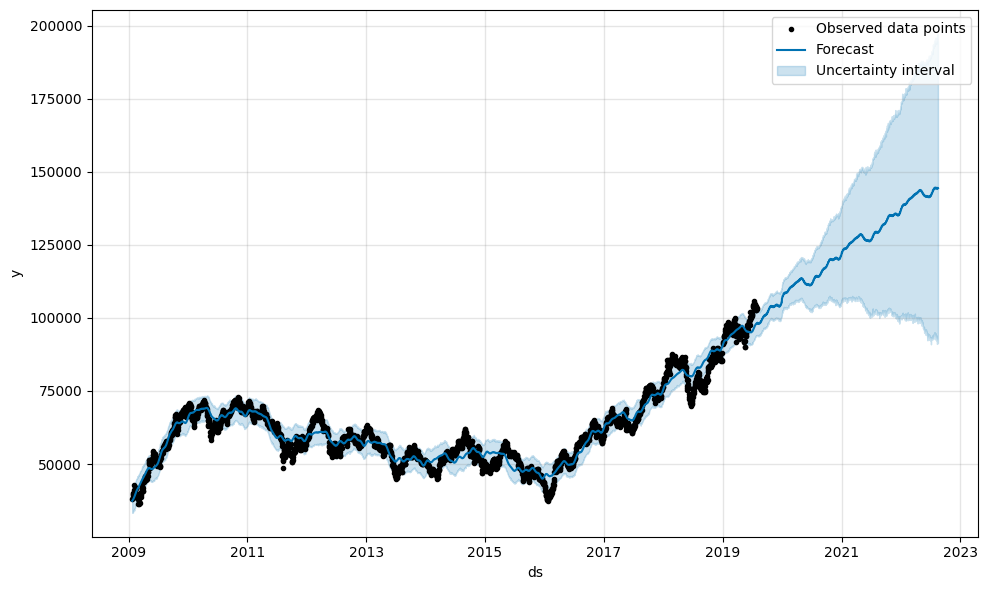

In [23]:
modelo2.plot(previsao_teste2)
plt.legend()
plt.show()

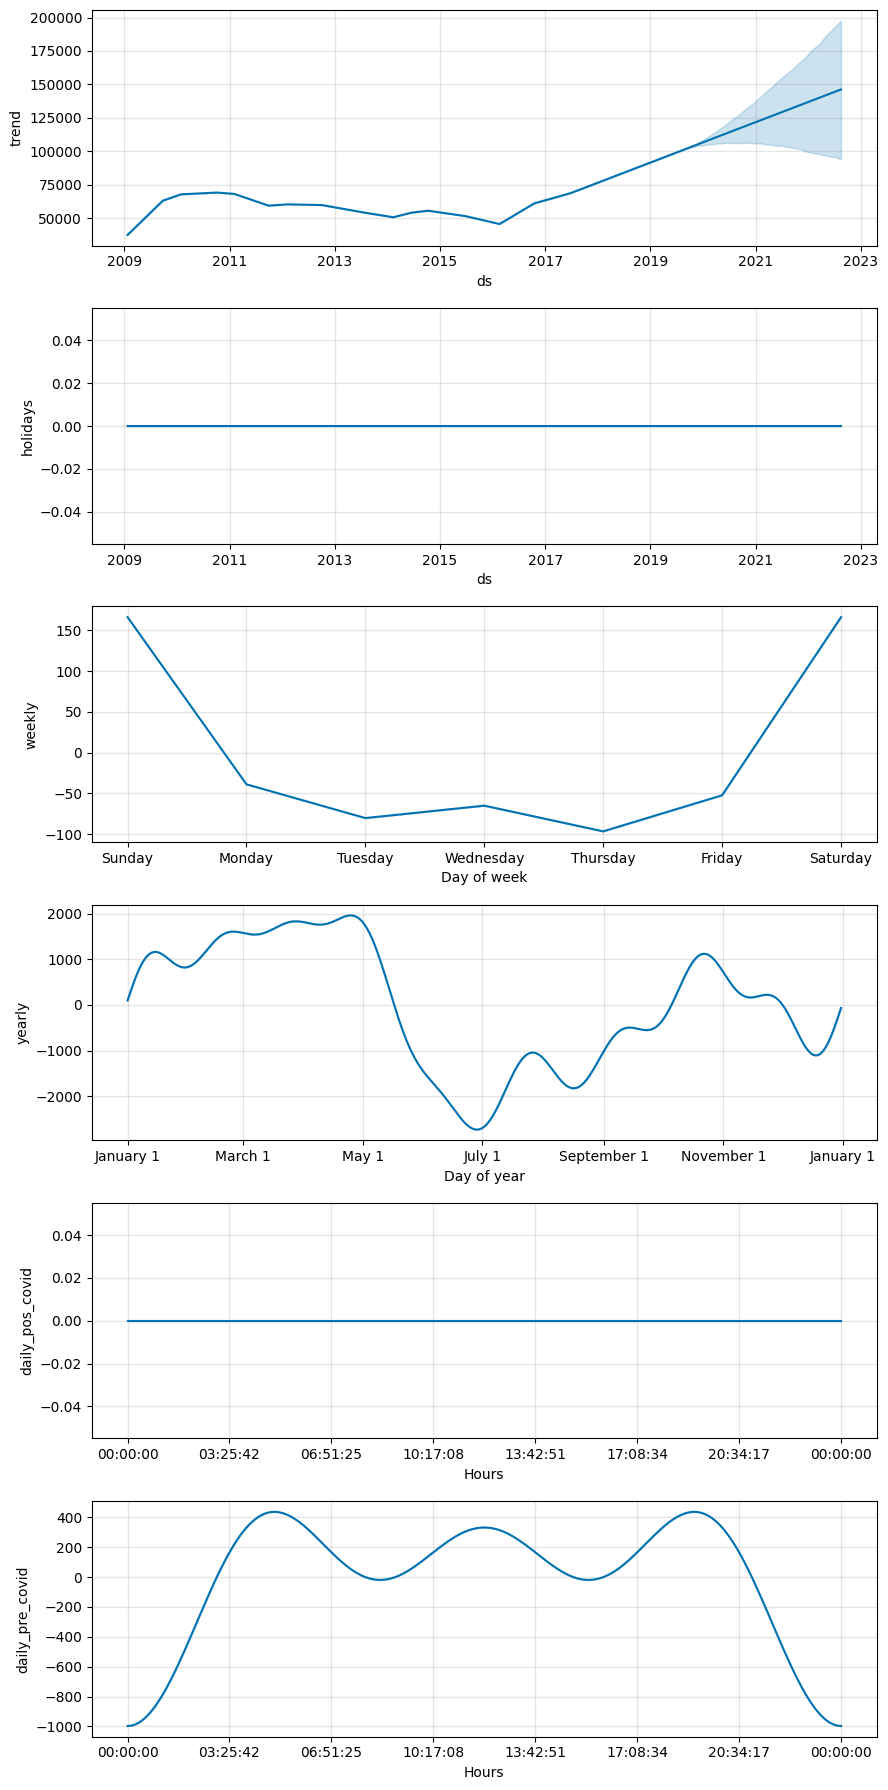

In [24]:
modelo2.plot_components(previsao_teste2)
plt.show()

## Validação do modelo2

In [25]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(modelo2, initial='1825 days', period='180 days', horizon = '730 days')
df_cv.head()


INFO:prophet:Making 8 forecasts with cutoffs between 2014-02-16 00:00:00 and 2017-07-30 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpq9vbznew/c03_lk8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq9vbznew/vq_siy6_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6412', 'data', 'file=/tmp/tmpq9vbznew/c03_lk8h.json', 'init=/tmp/tmpq9vbznew/vq_siy6_.json', 'output', 'file=/tmp/tmpq9vbznew/prophet_modelyax9og5u/prophet_model-20240123152324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:23:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:23:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq9vbznew/o7peyagw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq9vbznew/tetneo5m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-02-17,49396.931944,46825.267440,52060.792367,47576.0,2014-02-16
1,2014-02-18,49291.690311,46558.117826,51955.639299,46600.0,2014-02-16
2,2014-02-19,49245.630487,46455.149535,52089.100904,47151.0,2014-02-16
3,2014-02-20,49290.586079,46356.352588,51918.347281,47289.0,2014-02-16
4,2014-02-21,49237.014457,46736.703559,51816.784391,47380.0,2014-02-16


In [26]:
from prophet.diagnostics import performance_metrics
pd.options.display.float_format = '{:.2f}'.format
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,73 days,39353809.21,6273.26,5181.27,0.09,0.08,0.10,0.41
1,74 days,40083865.63,6331.18,5228.64,0.10,0.08,0.10,0.40
2,75 days,40671508.16,6377.42,5259.24,0.10,0.08,0.10,0.40
3,76 days,41181263.49,6417.26,5280.86,0.10,0.08,0.10,0.41
4,77 days,41545423.37,6445.57,5286.86,0.10,0.08,0.10,0.41


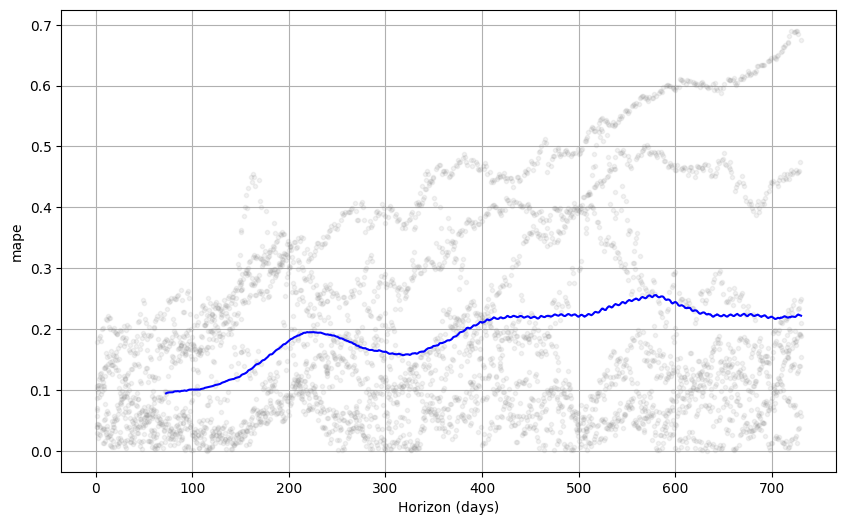

In [27]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [28]:
mean_absolute_error(dados2['y'],previsao_teste2['yhat'])

6687.881967992734

In [29]:
mean_absolute_percentage_error(dados2['y'],previsao_teste2['yhat'])

0.07645704803885907

## criando o segundo modelo - ref.: modelo3

In [30]:
# o dataser dados3 foi gerado lá em cima
dados3

,ds,y
0,2009-01-23,38132.00
1,2009-01-26,38509.00
2,2009-01-27,38699.00
3,2009-01-28,40227.00
4,2009-01-29,39638.00
...,...,...
3458,2024-01-17,128524.00
3459,2024-01-18,127316.00
3460,2024-01-19,127636.00
3461,2024-01-22,126602.00


In [31]:
dados_treino3, dados_teste3 = train_test_split(dados3, test_size=0.3, shuffle=False)

In [32]:
period3 = dados_teste3.shape[0]

In [33]:
# criando um modelo com o prophet
modelo3 = Prophet(seasonality_mode='additive', daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)

# adicionando os feriados
modelo3.add_country_holidays(country_name='BR')

# treinando o modelo
modelo3.fit(dados_treino3)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpq9vbznew/7qh52z1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq9vbznew/o4j6c5_q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29588', 'data', 'file=/tmp/tmpq9vbznew/7qh52z1n.json', 'init=/tmp/tmpq9vbznew/o4j6c5_q.json', 'output', 'file=/tmp/tmpq9vbznew/prophet_modelgut9ijfq/prophet_model-20240123152344.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:23:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:23:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [34]:
futuro3 = modelo3.make_future_dataframe(freq='D', periods=period3)

In [35]:
previsao_teste3 = modelo3.predict(futuro3)

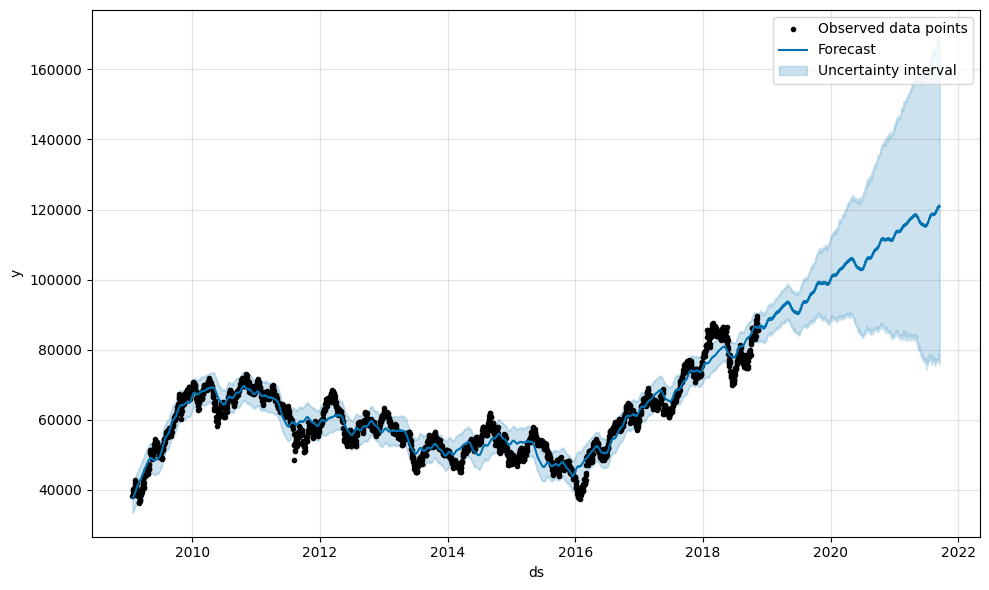

In [36]:
modelo3.plot(previsao_teste3)
plt.legend()
plt.show()

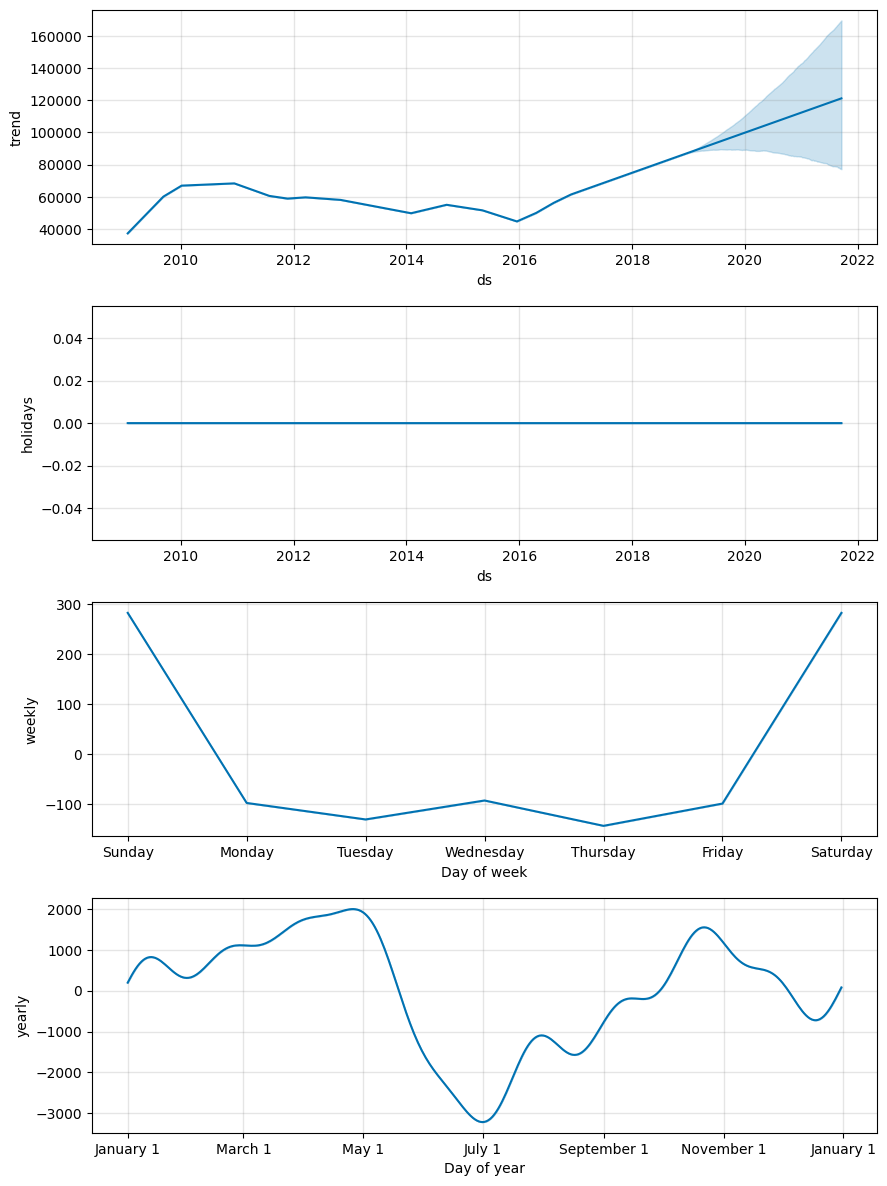

In [37]:
modelo3.plot_components(previsao_teste3)
plt.show()

In [42]:
df_cv3 = cross_validation(modelo3, initial='1825 days', period='30 days', horizon = '730 days')
df_cv3.head()

INFO:prophet:Making 35 forecasts with cutoffs between 2014-01-27 00:00:00 and 2016-11-12 00:00:00


  0%|          | 0/35 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpq9vbznew/pw2dlqx3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq9vbznew/eh3qgr7j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54057', 'data', 'file=/tmp/tmpq9vbznew/pw2dlqx3.json', 'init=/tmp/tmpq9vbznew/eh3qgr7j.json', 'output', 'file=/tmp/tmpq9vbznew/prophet_model7xq_uszi/prophet_model-20240123152703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:27:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:27:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq9vbznew/xddti2qi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq9vbznew/af_wp53y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-01-28,51253.87,48660.65,53890.84,47841.00,2014-01-27
1,2014-01-29,51181.24,48567.68,53827.29,47557.00,2014-01-27
2,2014-01-30,51206.57,48649.44,53696.17,47244.00,2014-01-27
3,2014-01-31,51138.25,48472.38,54023.07,47639.00,2014-01-27
4,2014-02-03,51081.65,48407.70,53902.61,46148.00,2014-01-27


In [43]:
pd.options.display.float_format = '{:.2f}'.format
df_p3 = performance_metrics(df_cv3)
df_p3.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,74 days,57618779.75,7590.70,6627.27,0.13,0.12,0.13,0.24
1,75 days,58434609.68,7644.25,6679.73,0.13,0.12,0.13,0.24
2,76 days,59055205.15,7684.74,6721.07,0.13,0.13,0.13,0.23
3,77 days,59599631.83,7720.08,6754.94,0.13,0.13,0.13,0.23
4,78 days,60207077.64,7759.32,6791.27,0.13,0.13,0.13,0.23


In [44]:
mean_absolute_error(dados3['y'],previsao_teste3['yhat'])

4521.0394166196

In [45]:
mean_absolute_percentage_error(dados3['y'],previsao_teste3['yhat'])

0.0548401265942315